<a href="https://colab.research.google.com/github/dimoynwa/Computer-vision-tasks/blob/main/EfficientNet_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EfficientNet algorithm from scratch using Pythorch

The EfficientNet official Paper: https://arxiv.org/pdf/1905.11946.pdf

Efficient Net Architecture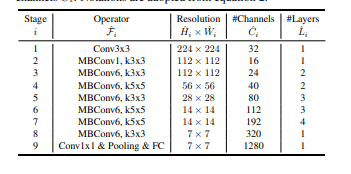

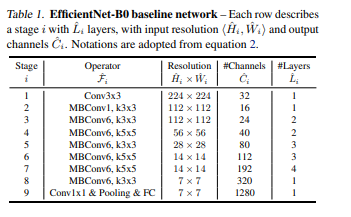

## Import libraries

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class ConvBlock(nn.Module):
  # We add the act=True, in some cases we do NOT need activation
  # Then we will use nn.Identity()
  def __init__(self, in_channels, out_channels, kernel_size, stride, groups=1, act=True, bias=False):
    super().__init__()
    padding = kernel_size // 2 # If kernel = 1 -> padding=0, if kernel = 3 -> padding = 1, if kernel = 5 -> padding 2
    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                          stride=stride, padding=padding, groups=groups, bias=bias)
    self.bn = nn.BatchNorm2d(out_channels)
    self.activation = nn.SiLU() if act else nn.Identity()

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.activation(x)
    return x


In [ ]:
x = torch.rand((2, 3, 224, 224))
bl = ConvBlock(3, 27, 3, 1, groups=3)

print(bl.forward(x).shape)

torch.Size([2, 27, 224, 224])


## Squeeze and Excitation block

The Squeeze-and-Excitation Block is an architectural unit designed to improve the representational power of a network by enabling it to perform dynamic channel-wise feature recalibration. The process is:

The block has a convolutional block as an input.
* Each channel is **"squeezed"** into a **single numeric value** using average pooling.
* A **dense layer** followed by a **ReLU** adds non-linearity and output channel complexity is reduced by a ratio.
* Another dense layer followed by a sigmoid gives each channel a smooth gating function.
* Finally, we weight each feature map of the convolutional block based on the side network; the "excitation".


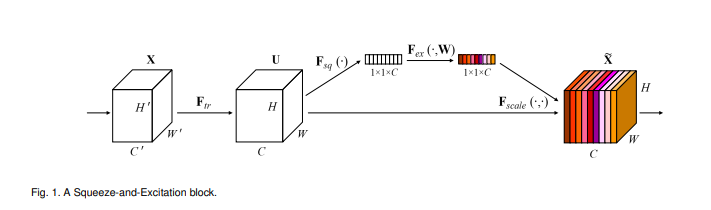

In [ ]:
class SEBlock(nn.Module):
  def __init__(self, in_channels, r=24):
    super().__init__()
    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc1 = nn.Linear(in_channels, in_channels//r, bias=False)
    self.fc2 = nn.Linear(in_channels//r, in_channels, bias=False)
    self.activation = nn.SiLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # x shape (num_samples, num_channels, height, width)
    factor = self.avg_pool(x)
    # Factor shape is (num_samples, num_channels, 1, 1)
    # Flatten before sending to Dense layers
    factor = torch.flatten(factor, 1)

    # After flatten the factor shape is (num_samples, num_channels)
    # Pass flattened to Dense layers and activate with SiLU
    factor = self.activation(self.fc1(factor))
    # Factor shape is (num_samples, in_channels // r)
    factor = self.sigmoid(self.fc2(factor))
    # Factor shape is (num_samples, in_channels)

    factor = factor[:,:,None, None]
    # Factor shape is (num_samples, in_channels, 1, 1)

    return x * factor


In [ ]:
x = torch.rand(2, 3, 224, 224)
se = SEBlock(3)

res = se(x)
print(f'Res shape {res.shape}')

Res shape torch.Size([2, 3, 224, 224])


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


## MBConv

Let's implement MBConv class from first image with EfficientNet Architecture.
So what is **exp** parameter. It means expansion and comes from the architecture.
For MbConv1 it will be 1, for MbConv6 it will be 6.

Parameter **r** is for SqueezeAndExcitation block. Reduce.

**Residual connections** is only applied if **input_channels == output_channels**


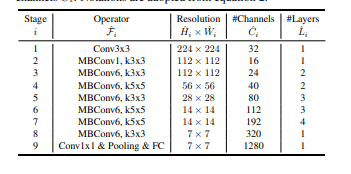

In [ ]:
class MBConv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, exp, r):
    super().__init__()
    exp_channels = in_channels * exp
    self.add = in_channels == out_channels and stride == 1

    self.conv1 = ConvBlock(in_channels, exp_channels, kernel_size=1, stride=1) if exp > 1 else nn.Identity()
    self.conv2 = ConvBlock(exp_channels, exp_channels, kernel_size=kernel_size, stride=stride, groups=exp_channels)
    self.se = SEBlock(exp_channels, r)
    # We don't use activation on the last layer
    self.conv3 = ConvBlock(exp_channels, out_channels, kernel_size=1, stride=1, act=False)


  def forward(self, x):
    f = self.conv1(x)
    f = self.conv2(f)
    f = self.se(f)
    f = self.conv3(f)

    if self.add:
      f = x * f

    return f

In [ ]:
x = torch.rand((2, 3, 224, 224))
mbc = MBConv(3, 64, 3, 1, 4, 1)

print(f'Output shape: {mbc(x).shape}')

Output shape: torch.Size([2, 64, 224, 224])


## Last block we need is the Classfier block.

Classifier block contains Conv 1x1 layer, Average pooling layer and a Dense layers for classification.

In [ ]:
class Classifier(nn.Module):
  def __init__(self, in_channels, num_classes, p):
    super().__init__()
    self.pool = nn.AdaptiveAvgPool2d((1, 1))
    self.dropout = nn.Dropout(p)
    self.fc1 = nn.Linear(in_channels, num_classes)


  def forward(self, x):
    # X shape is (num_samples, num_channels, height, width)
    x = self.pool(x)
    # X shape is (num_samples, num_channels, 1, 1)
    x = self.dropout(x)
    # X shape is (num_samples, num_channels, 1, 1)
    x = torch.flatten(x, 1)
    # X shape is (num_samples, num_channels)
    x = self.fc1(x)
    # X shape is (num_samples, num_classes)
    return x



In [ ]:
x = torch.rand((2, 3, 224, 224))
clsr = Classifier(3, 10, .8)

print(f'Output shape: {clsr(x).shape}')

Output shape: torch.Size([2, 10])


## Efficient Net itself.

Implementing EfficientNet class itself. Again I will put the image with the architecture to be easier, while implementing it.

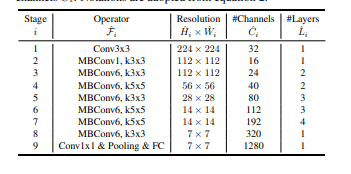

In [ ]:
stages = [
    # Class, channels, layers, kernel, stride, expansion
    [ConvBlock, 32, 1, 3, 2, 1 ],
    [MBConv, 16, 1, 3, 1, 1],
    [MBConv, 24, 2, 3, 2, 6],
    [MBConv, 40, 2, 5, 2, 6],
    [MBConv, 80, 3, 3, 2, 6],
    [MBConv, 112, 3, 5, 1, 6],
    [MBConv, 192, 4, 5, 2, 6],
    [MBConv, 320, 1, 3, 1, 6],
    [ConvBlock, 1280, 1, 1, 1, 0 ]
]

phis = {
    'B0': (0, 224, .2),
    'B1': (.5, 240, .2),
    'B2': (1, 260, .3),
    'B3': (2, 300, .3),
    'B4': (3, 380, .4),
    'B5': (4, 456, .4),
    'B6': (5, 528, .5),
    'B7': (6, 600, .5)
}


In [ ]:
class EfficientNet(nn.Module):
  def __init__(self, stages, phis, in_channels=3, num_classes=1000):
    super().__init__()
    # Parameters
    # Get coef, resolution and dropout rate from phis
    phi, res, p = phis
    self._calculate_coef(phi)

    # Network
    self.net = nn.ModuleList([])
    self.channels = []

    # First stage
    cls, ch, layers, kernel, stride, expansion = stages[0]
    self._add_layer(in_channels, cls, ch, layers, kernel, stride)

    # Stages 2-8
    for idx in range(1, len(stages) - 1):
      r = 4 if idx == 1 else 24

      cls, ch, layers, kernel, stride, expansion = stages[idx]
      in_chans = self.channels[-1] # The last element
      self._add_layer(in_chans, cls, ch, layers, kernel, stride, expansion, r)


    # Last stage (Stage 9)
    cls, ch, layers, kernel, stride, expansion = stages[-1]
    in_chans = self.channels[-1] # The last element
    self._add_layer(in_chans, cls, ch, layers, kernel, stride)

    # Classifier
    self.net.append(Classifier(self.channels[-1], num_classes, p))


  def forward(self, x):
    stg = 1
    for F in self.net:
      _, in_channels, heigth, width = x.shape

      x = F(x)
      # On change of shape
      if in_channels != x.shape[1] and stg < 10:
        print(f'Stage {stg}: New in_channels: {x.shape[1]}, (h,w) {(heigth, width)}')
        stg += 1

    return x

  def _add_layer(self, in_channels, cls, chans, layers, kernel, stride, *args):
    chans, layers = self._update_feat(chans, layers)

    if layers == 1:
      self.net.append(cls(in_channels, chans, kernel, stride, *args))

    else:
      # 1 layer with stride 1
      self.net.append(cls(in_channels, chans, kernel, 1, *args))

      # Middle layers
      for _ in range(layers - 2):
        self.net.append(cls(chans, chans, kernel, 1, *args))

      # Final layer
      self.net.append(cls(chans, chans, kernel, stride, *args ))

    self.channels.append(chans)

  def _calculate_coef(self, phi, alpha=1.2, beta=1.1):
    self.depth = alpha ** phi
    self.width = beta ** phi

  def _update_feat(self, channels, layers):
    return int(channels * self.width), int(layers * self.depth)


In [ ]:
version = 'B3'

ph, res, r = phis[version]

net = EfficientNet(stages, phis[version], num_classes=10)

input = torch.rand((5, 3, res, res))
output = net(input)

print(f'Output: {output.shape}')

Stage 1: New in_channels: 38, (h,w) (300, 300)
Stage 2: New in_channels: 19, (h,w) (150, 150)
Stage 3: New in_channels: 29, (h,w) (150, 150)
Stage 4: New in_channels: 48, (h,w) (75, 75)
Stage 5: New in_channels: 96, (h,w) (38, 38)
Stage 6: New in_channels: 135, (h,w) (19, 19)
Stage 7: New in_channels: 232, (h,w) (19, 19)
Stage 8: New in_channels: 387, (h,w) (10, 10)
Stage 9: New in_channels: 1548, (h,w) (10, 10)
Output: torch.Size([5, 10])
